In [3]:
import glob
from pathlib import Path
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.optimizers import Adam
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

def create_model(base_model, classData):
    for layer in base_model.layers:
        layer.trainable = False
            
    top_model = base_model.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    
    output_layer = Dense(classData, activation='softmax')(top_model)

    model = Model(inputs=base_model.input, outputs=output_layer)

    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])        
            
    return model


train_path = '/content/drive/MyDrive/PaddyDisease/Aug_UnderSampling_Dataset/train'
test_path  = '/content/drive/MyDrive/PaddyDisease/Aug_UnderSampling_Dataset/test'
IMG_SHAPE = (256, 256, 3)
batch_size = 32
classData = 10

base_model = MobileNetV3Large(
    include_top=False,
    alpha=1.0,
    weights="imagenet",
    input_shape=IMG_SHAPE,
)

model = create_model(base_model, classData)
# model.summary()

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.1,
    subset="training",
    seed=123,
    label_mode='categorical',
    image_size=(256,256),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.1,
    subset="validation",
    seed=123,
    label_mode="categorical",
    image_size=(256,256),
    batch_size=batch_size
)

Found 3030 files belonging to 10 classes.
Using 2727 files for training.
Found 3030 files belonging to 10 classes.
Using 303 files for validation.


In [5]:
#custom callback
#checkpoint = ModelCheckpoint("rcnnplatemodel.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=3)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
86/86 [==============================] - 656s 7s/step - loss: 1.8763 - accuracy: 0.5900 - val_loss: 0.7481 - val_accuracy: 0.7888
Epoch 2/10
86/86 [==============================] - 255s 3s/step - loss: 0.0887 - accuracy: 0.9791 - val_loss: 0.6872 - val_accuracy: 0.8416
Epoch 3/10
86/86 [==============================] - 269s 3s/step - loss: 0.0227 - accuracy: 0.9974 - val_loss: 0.6171 - val_accuracy: 0.8548
Epoch 4/10
86/86 [==============================] - 294s 3s/step - loss: 0.0158 - accuracy: 0.9982 - val_loss: 0.6665 - val_accuracy: 0.8350
Epoch 5/10
86/86 [==============================] - 277s 3s/step - loss: 0.0048 - accuracy: 0.9996 - val_loss: 0.6627 - val_accuracy: 0.8482
Epoch 6/10
86/86 [==============================] - 258s 3s/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.6550 - val_accuracy: 0.8482


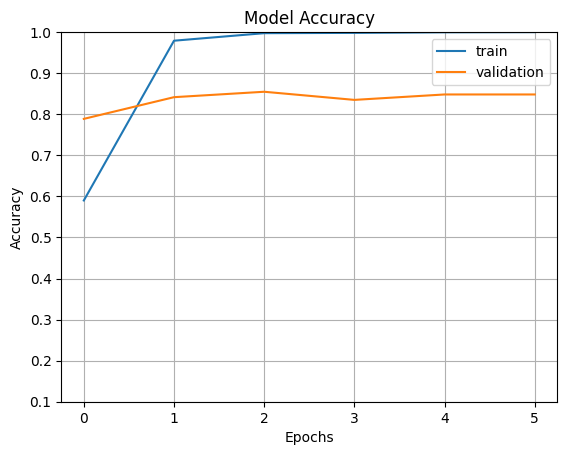

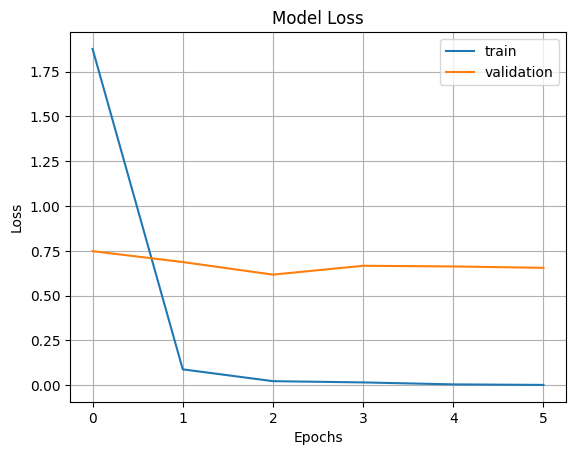

In [6]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.1,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [7]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    shuffle=False,
    label_mode="categorical",
    image_size=(256,256),
    batch_size=1
)

predictions = model.predict(test_ds)

Found 340 files belonging to 10 classes.
340/340 [==============================] - 78s 223ms/step


In [8]:
import numpy as np
from sklearn.metrics import classification_report

class_names = ["bacterial_leaf_blight","bacterial_leaf_streak","bacterial_panicle_blight","blast","brown_spot","dead_heart","downy_mildew","hispa","normal","tungro"]

predicted_categories = np.argmax(predictions, axis=1)

true_categories = tf.concat([y for x, y in test_ds], axis=0).numpy()
true_categories_argmax = np.argmax(true_categories, axis=1)

print(classification_report(true_categories_argmax, predicted_categories, target_names=class_names))

                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.89      0.91      0.90        34
   bacterial_leaf_streak       0.97      0.94      0.96        34
bacterial_panicle_blight       0.97      0.97      0.97        34
                   blast       0.77      0.79      0.78        34
              brown_spot       0.93      0.74      0.82        34
              dead_heart       0.91      0.91      0.91        34
            downy_mildew       0.80      0.71      0.75        34
                   hispa       0.69      0.74      0.71        34
                  normal       0.78      0.82      0.80        34
                  tungro       0.70      0.82      0.76        34

                accuracy                           0.84       340
               macro avg       0.84      0.84      0.84       340
            weighted avg       0.84      0.84      0.84       340



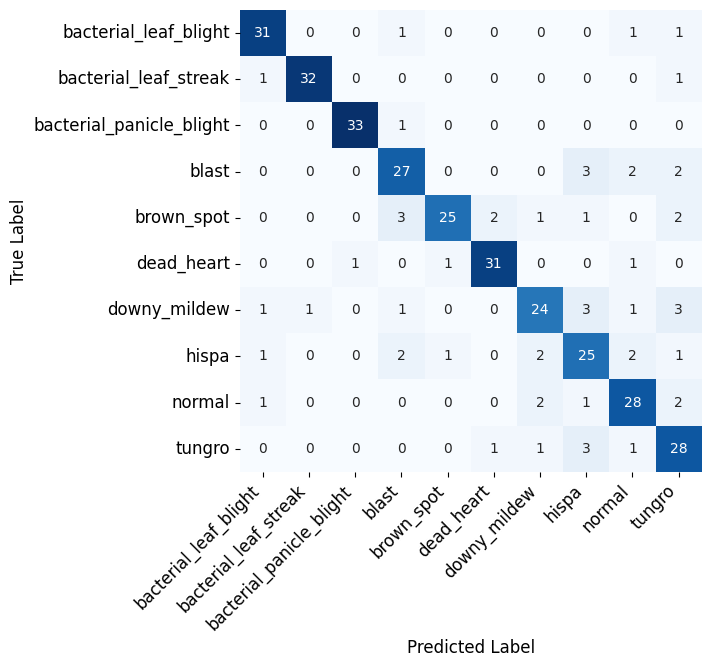

In [9]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    #ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plot_heatmap(true_categories_argmax, predicted_categories, class_names, ax, title="EfficientNetV2B0-UnderSampling")    

#fig.suptitle("Confusion Matrix Model Comparison", fontsize=12)
#fig.tight_layout()
#fig.subplots_adjust(top=1.25)
plt.show()

In [10]:
model.save('/content/drive/MyDrive/PaddyDisease/MobileNetV3Large/PaddyDisease_MobileNetV3Large_UnderSampling.h5')